<a href="https://colab.research.google.com/github/AEW2015/altera_examples/blob/main/py_AI/colab/mnist_live_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Live Demo

## MNIST References

* [Colab Pytorch example](https://github.com/rafaela00castro/pytorch-hands-on/blob/master/mnist_cnn.ipynb)
* [Interactive MNIST Demo](https://adamharley.com/nn_vis/cnn/2d.html)

## Get Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split, DataLoader

from torchvision import datasets, transforms
from torchvision.utils import make_grid

%matplotlib inline

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
seed = 15
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic=True

In [4]:
# Custom transform to flatten, pad, and reshape the tensor
class FlattenPadAndReshapeTransform:
    def __init__(self, target_shape=(3, 16, 17)):
        self.target_shape = target_shape
        self.target_size = target_shape[0] * target_shape[1] * target_shape[2]  # 3 * 16 * 17 = 816

    def __call__(self, tensor):
        # Flatten the input tensor to shape [784]
        flattened = tensor.view(-1)

        # Create a new tensor of the target size filled with zeros
        padded = torch.zeros(self.target_size)

        # Copy the flattened values into the new padded tensor
        padded[:flattened.size(0)] = flattened

        # Reshape to the target shape [3, 16, 17]
        return padded.view(*self.target_shape)

Adding the extra 2 channels below to match Video DMA on FPGA AI Demo Bitstream

In [5]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                                transforms.Lambda(lambda x: x.repeat(3, 1, 1))  # Repeat grayscale 3 times
                              ])

In [6]:
batch_size = 20
num_workers = 4

full_train_dataset = datasets.MNIST(root='./data', train=True,
                            download=True, transform=transform)

test_data = datasets.MNIST(root='./data', train=False,
                           download=True, transform=transform)

train_data, val_data = random_split(full_train_dataset, [50000, 10000])


train_loader = DataLoader(train_data, batch_size=batch_size,
                          shuffle=True, num_workers=num_workers)

val_loader = DataLoader(val_data, batch_size=batch_size,
                          shuffle=False, num_workers=num_workers)

test_loader = DataLoader(test_data, batch_size=batch_size,
                         shuffle=False, num_workers=num_workers)

print('Size of full training dataset: ', len(full_train_dataset))
print('Size of training dataset: ', len(train_data))
print('Size of valitation dataset: ', len(val_data))
print('Size of test dataset: ', len(test_data))

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 34.3MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 964kB/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 9.38MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.89MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Size of full training dataset:  60000
Size of training dataset:  50000
Size of valitation dataset:  10000
Size of test dataset:  10000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [7]:
def imshow(img_tensor):
  """
  function to show an image
  """
  img_tensor = img_tensor / 2 + 0.5     # unnormalize
  img_numpy = img_tensor.numpy()        # from tensor to numpy
  plt.imshow(np.transpose(img_numpy, (1, 2, 0)))
  plt.show()

In [8]:
data_iter = iter(train_loader)
images, labels = next(data_iter)
print('(batch size, channels, height, width) ', images.shape)

(batch size, channels, height, width)  torch.Size([20, 3, 28, 28])


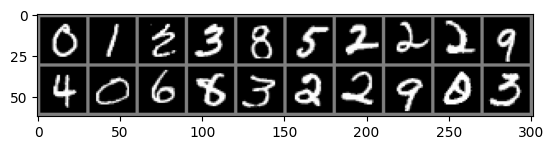

LABELS
 tensor([0, 1, 2, 3, 8, 5, 2, 2, 2, 9, 4, 0, 6, 8, 3, 2, 2, 9, 0, 3])


In [9]:
imshow(make_grid(images, nrow=10))
print('LABELS\n', labels)

## Design Model

Removing the extra 2 channels in the model (costing some performance)

In [10]:
import torch.nn as nn

class Channel1Extractor(nn.Module):
    def __init__(self):
        super(Channel1Extractor, self).__init__()

    def forward(self, x):
        return x[:, 0:1, :, :]

In [11]:
class ConvNet(nn.Module):

  def __init__(self):
    super(ConvNet, self).__init__()
    self.layer1 = nn.Sequential(
        Channel1Extractor(),
        nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=5, stride=2))

    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))

    self.fc1 = nn.Linear(20*4*4, 50)
    self.fc2 = nn.Linear(50, 10)
    self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = x.view(-1, 20*4*4) # Flatten layer
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)

    return x

In [12]:
model = ConvNet().to(device)
print(model)

ConvNet(
  (layer1): Sequential(
    (0): Channel1Extractor()
    (1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


## Train Model

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [14]:
%%time
num_epochs = 15
train_losses, val_losses = [], []

for epoch in range(1, num_epochs + 1):
    train_loss, val_loss = 0.0, 0.0

    model.train() # prepare model for training
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # clear the gradients
        optimizer.zero_grad()
        # forward pass: compute predicted outputs
        output = model(inputs)
        # calculate the loss
        loss = criterion(output, labels)
        # backward pass: compute gradient
        loss.backward()
        # perform a optimization step (weight update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()

    model.eval() # validate the model
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)
            loss = criterion(output, labels)
            val_loss += loss.item()

    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader)
    val_loss = val_loss/len(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, val_loss))

Epoch: 1 	Training Loss: 2.261576 	Validation Loss: 2.186220
Epoch: 2 	Training Loss: 1.691484 	Validation Loss: 0.857119
Epoch: 3 	Training Loss: 0.690177 	Validation Loss: 0.422630
Epoch: 4 	Training Loss: 0.422145 	Validation Loss: 0.275702
Epoch: 5 	Training Loss: 0.312270 	Validation Loss: 0.208878
Epoch: 6 	Training Loss: 0.249340 	Validation Loss: 0.172952
Epoch: 7 	Training Loss: 0.210235 	Validation Loss: 0.148682
Epoch: 8 	Training Loss: 0.183490 	Validation Loss: 0.131336
Epoch: 9 	Training Loss: 0.162789 	Validation Loss: 0.120263
Epoch: 10 	Training Loss: 0.150512 	Validation Loss: 0.111598
Epoch: 11 	Training Loss: 0.140193 	Validation Loss: 0.104420
Epoch: 12 	Training Loss: 0.130647 	Validation Loss: 0.098664
Epoch: 13 	Training Loss: 0.122631 	Validation Loss: 0.094519
Epoch: 14 	Training Loss: 0.117196 	Validation Loss: 0.090343
Epoch: 15 	Training Loss: 0.110120 	Validation Loss: 0.087708
CPU times: user 9min 7s, sys: 27.6 s, total: 9min 34s
Wall time: 12min 39s


## Export Model with OpenVINO

In [15]:
pip install openvino==2023.3.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 10.3 MB/s eta 0:00:00


In [16]:
import openvino as ov

In [17]:
ov_model = ov.convert_model(model,input=[1,3, 28, 28])

In [18]:
ov.save_model(ov_model, 'mnist_3x.xml')

## DLA Compile Commands

Example command for the FPGA AI DLA compiler

```

dla_compiler --march $COREDLA_ROOT/example_architectures/AGX7_Performance.arch --network-file ./mnist_3x.xml --foutput-format=open_vino_hetero --o $COREDLA_WORK/demo/mnist_perf.bin --batch-size=1 --fanalyze-performance

dla_compiler --march $COREDLA_ROOT/example_architectures/AGX7_Performance.arch --network-file ./mnist_3x.xml --foutput-format=open_vino_hetero --o $COREDLA_WORK/demo/mnist_stream.bin --batch-size=1 --fanalyze-performance --ffolding-option=0


uio-devices restart
export compiled_model=~/resnet-50-tf/mnist_perf.bin
export imgdir=~/resnet-50-tf/sample_images
export archfile=~/resnet-50-tf/AGX7_Performance.arch
cd ~/app
export COREDLA_ROOT=/home/root/app
./dla_benchmark -b=1 -cm $compiled_model -d=HETERO:FPGA,CPU -i $imgdir -niter=5 -plugins_xml_file ./plugins.xml -arch_file $archfile -api=async -perf_est  -nireq=4 -bgr


dla_compiler --fanalyze-area --march $COREDLA_ROOT/example_architectures/AGX7_Performance.arch

dla_compiler --gen-arch --mmax-resources=427200,2713,1518 --gen-min-sb=2048 --network-file ./mnist_3x.xml --march=$COREDLA_ROOT/example_architectures/AGX7_Performance.arch --mmax-resources-alm-util=75 --fassumed-fmax-core=300 --network-weightings=1 2

dla_compiler --fanalyze-area --march ./generated_arch.arch

dla_compiler --gen-arch --mmax-resources=427200,2713,1518 --gen-min-sb=2048 --network-file ./mnist_3x.xml --march=$COREDLA_ROOT/example_architectures/AGX7_Performance.arch --mmax-resources-alm-util=75 --fassumed-fmax-core=300 --network-weightings=1 --mtarget-fps=100.0

dla_compiler --fanalyze-area --march ./generated_arch.arch
```